# 📝 Exercise M6.03

The aim of this exercise is to:

* verifying if a random forest or a gradient-boosting decision tree overfit
  if the number of estimators is not properly chosen;
* use the early-stopping strategy to avoid adding unnecessary trees, to
  get the best generalization performances.

We will use the California housing dataset to conduct our experiments.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

Create a gradient boosting decision tree with `max_depth=5` and
`learning_rate=0.5`.

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(max_depth=5, learning_rate=.5)

In [11]:
gradient_boosting.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.5,
 'loss': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


Also create a random forest with fully grown trees by setting `max_depth=None`.

In [3]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(max_depth=None)


For both the gradient-boosting and random forest models, create a validation
curve using the training set to assess the impact of the number of trees on
the performance of each model. Evaluate the list of parameters `param_range =
[1, 2, 5, 10, 20, 50, 100]` and use the mean absolute error.

In [4]:
from sklearn.model_selection import validation_curve
# from sklearn.model_selection import ShuffleSplit

# cv = ShuffleSplit(n_splits=30, test_size=0.2)
param_range = [1, 2, 5, 10, 20, 50, 100]

In [18]:
train_boost, test_boost = validation_curve(gradient_boosting, data_train, target_train, param_name="n_estimators", param_range=param_range, scoring="neg_mean_absolute_error", n_jobs=2)
train_boost_err, test_boost_err = -train_boost, -test_boost

In [19]:
train_forest, test_forest = validation_curve(random_forest, data_train, target_train, param_name="n_estimators", param_range=param_range, scoring="neg_mean_absolute_error", n_jobs=2)
train_forest_err, test_forest_err = -train_forest, -test_forest

In [20]:
print(train_boost_err.mean(axis=1)) 
print(test_boost_err.mean(axis=1)) 
print(train_forest_err.mean(axis=1)) 
print(test_forest_err.mean(axis=1))

[64.53226116 52.26023649 38.2351955  33.38666306 29.03975184 22.6139013
 17.08205134]
[65.55551299 53.99185594 41.39270342 38.38310098 36.54417414 35.7413204
 35.63068311]
[19.00673811 17.99280672 16.27546825 14.92848977 13.94048009 13.2664295
 13.06680386]
[51.4242376  43.84313285 39.74130233 37.05223078 35.93601109 34.92479044
 34.91890218]


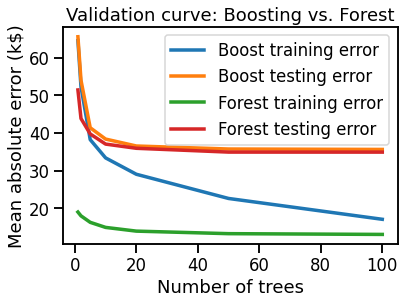

In [21]:
import matplotlib.pyplot as plt

plt.plot(param_range, train_boost_err.mean(axis=1), label="Boost training error")
plt.plot(param_range, test_boost_err.mean(axis=1), label="Boost testing error")
plt.plot(param_range, train_forest_err.mean(axis=1), label="Forest training error")
plt.plot(param_range, test_forest_err.mean(axis=1), label="Forest testing error")

plt.legend()

plt.xlabel("Number of trees")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve: Boosting vs. Forest")

Both gradient boosting and random forest models will always improve when
increasing the number of trees in the ensemble. However, it will reach a
plateau where adding new trees will just make fitting and scoring slower.

To avoid adding new unnecessary tree, unlike random-forest gradient-boosting
offers an early-stopping option. Internally, the algorithm will use an
out-of-sample set to compute the generalization performance of the model at
each addition of a tree. Thus, if the generalization performance is not
improving for several iterations, it will stop adding trees.

Now, create a gradient-boosting model with `n_estimators=1_000`. This number
of trees will be too large. Change the parameter `n_iter_no_change` such
that the gradient boosting fitting will stop after adding 5 trees that do not
improve the overall generalization performance.

In [26]:
gradient_boosting2 = GradientBoostingRegressor(n_estimators=1000, n_iter_no_change=5)
gradient_boosting2.fit(data_train, target_train)

GradientBoostingRegressor(n_estimators=1000, n_iter_no_change=5)

In [27]:
1000 == 1_000
gradient_boosting2.n_estimators_

184

Estimate the generalization performance of this model again using
the `sklearn.metrics.mean_absolute_error` metric but this time using
the test set that we held out at the beginning of the notebook.
Compare the resulting value with the values observed in the validation
curve.

In [28]:
from sklearn.metrics import mean_absolute_error

grad_predict = gradient_boosting2.predict(data_test)
grad_score = mean_absolute_error(target_test, grad_predict)

In [29]:
grad_score

35.40689443752345

 We can observe that the final evaluation of the test error seems to be even slightly below than the cross-validated test scores. This can be explained because the final model has been trained on the full training set while the cross-validation models have been trained on smaller subsets: in general the larger the number of training points, the lower the test error.